<center>
    
# Temporal-Difference Methods, Cliffwalking

</center>

<img src="../../_aux/images/matengai-of-kuniga-coast-in-oki-island-shimane-pref600.jpg">
Source: wikipedia

### Notes

**CliffWalking environment**

This is a simple implementation of the Gridworld Cliff
reinforcement learning task.

Adapted from **Example 6.6 from Reinforcement Learning: An Introduction
by Sutton and Barto**:
http://people.inf.elte.hu/lorincz/Files/RL_2006/SuttonBook.pdf

With inspiration from:
https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

The board is a **4x12 matrix**, with (using Numpy matrix indexing):
   
    [3, 0] as the start at bottom-left
    [3, 11] as the goal at bottom-right
    [3, 1..10] as the cliff at bottom-center
    
Each time step incurs **-1 reward**, and stepping into the cliff incurs **-100 reward**
and a reset to the start. An episode terminates when the agent reaches the goal.

---

The agent moves through a **$4\times 12$ gridworld**, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the **initial state**.  State `47` is the only **terminal state**, and the cliff corresponds to states `37` through `46`.

The agent has **4 potential actions**:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.


### Import Packages

In [8]:
import sys
import gym
import numpy as np
import random
import math
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

### Set Environment

In [2]:
# initialize environment
env = gym.make('CliffWalking-v0')

In [3]:
# environment info
print('State space:', env.observation_space)
print('Action space:', env.action_space)
print('Total number of states', env.nS)
print('Total number of actions', env.nA)
print('Environment Display:')
env.render()

State space: Discrete(48)
Action space: Discrete(4)
Total number of states 48
Total number of actions 4
Environment Display:
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



### Define the optimal state-value function

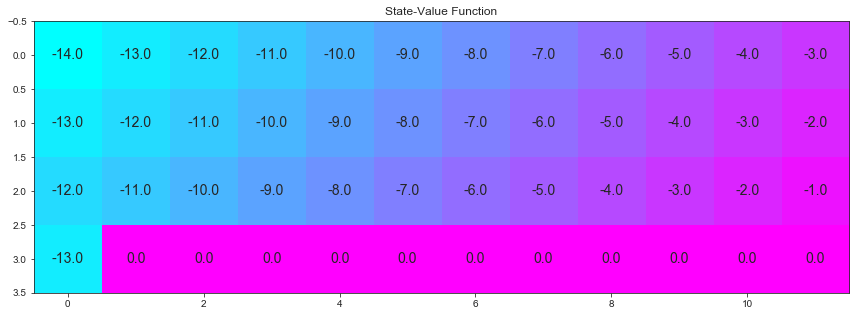

In [4]:
# option 2
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### TD Prediction: State Values

implementation of TD prediction (for estimating the state-value function).
trial on a policy where the agent moves:

- RIGHT in states 0 through 10, inclusive,
- DOWN in states 11, 23, and 35, and
- UP in states 12 through 22, inclusive, states 24 through 34, inclusive, and state 36.

The policy is specified and printed below. Note that states where the agent does not choose an action have been marked with -1.

In [20]:
policy = np.hstack([1*np.ones(11), 2, 0, np.zeros(10), 2, 0, np.zeros(10), 2, 0, -1*np.ones(11)])
print("\nPolicy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy.reshape(4,12))


Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]


In [23]:
def td_prediction(env, num_episodes, policy, alpha, gamma=1.0):
    """
    this function approximates the state function by interacting with the environment
    for a fixed number of episodes the state function is improved in each step
    """    
    # initialize V as a dictionaries of floats with values 0
    V = defaultdict(float)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # start the episode by resetting the environment 
        state = env.reset()
        
        # go through the episode
        while True:
            # perform the next step
            action = policy[state]
            next_state, reward, done, _ = env.step(action)
            
            # now immediately update the state function in every step with that
            # steps reward + the discounted next steps reward 
            # use what ever state function you have for each state to calculate the updata
            """
            TD prediction update rule
            ---
            TD_target = reward + gamma * V[next_state]
            TD_error = TD_target - V[state]
            V[state] = V[state] + (alpha * TD_error)
            """
            V[state] = (1 - alpha) * V[state] + alpha * (reward + gamma * V[next_state])
            
            # set the state to the next state in order to continue the episode
            state = next_state
            
            # check whether the episode ended
            if done:
                break
        
    # finally return the approximated state function for the policy
    return V 

Episode 500000/500000

**<span style="color: green;">PASSED</span>**

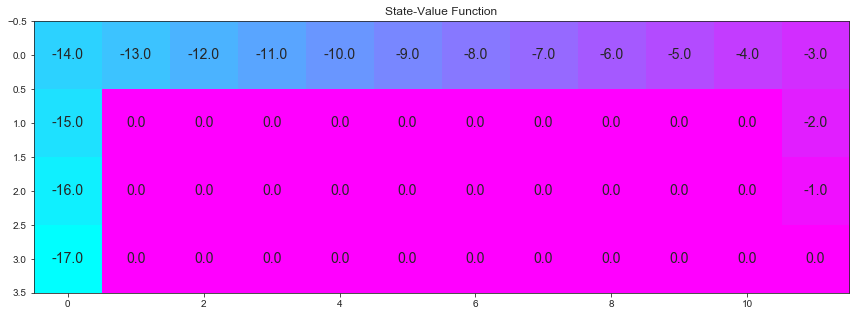

In [25]:
# evaluate the policy and reshape the state-value function
V_pred = td_prediction(env, 500000, policy, .01)

# please do not change the code below this line
V_pred_plot = np.reshape([V_pred[key] if key in V_pred else 0 for key in np.arange(48)], (4,12)) 
check_test.run_check('td_prediction_check', V_pred_plot)
plot_values(V_pred_plot)

### TD Control: Sarsa

In [5]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    # get value of state, action pair at next time step
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0    
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value
    return new_value

def epsilon_greedy(Q, state, nA, eps):
    """Selects epsilon-greedy action for supplied state.
    
    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """
    if random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return random.choice(np.arange(env.action_space.n))

In [6]:
def sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        score = 0                                             # initialize score
        state = env.reset()                                   # start episode
        
        eps = 1.0 / i_episode                                 # set value of epsilon
        action = epsilon_greedy(Q, state, nA, eps)            # epsilon-greedy action selection
        
        while True:
            next_state, reward, done, info = env.step(action) # take action A, observe R, S'
            score += reward                                   # add reward to agent's score
            if not done:
                next_action = epsilon_greedy(Q, next_state, nA, eps) # epsilon-greedy action
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward, next_state, next_action)
                
                state = next_state     # S <- S'
                action = next_action   # A <- A'
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
                tmp_scores.append(score)    # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))

    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))    
    return Q

Episode 5000/5000

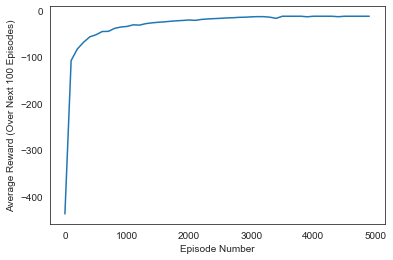

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  2  1  1  3  2  1  1  1  1  0  3]
 [ 1  1  2  1  1  1  1  1  2  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


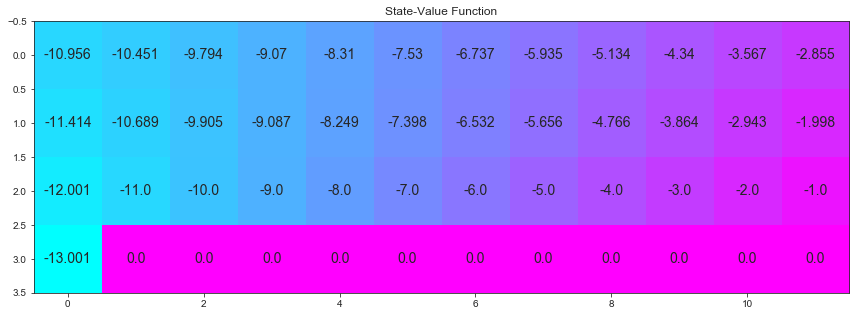

In [10]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### TD Control: Q-learning

In [11]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    Qsa_next = np.max(Q[next_state]) if next_state is not None else 0  # value of next state 
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value 
    return new_value

In [12]:
def q_learning(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    """Q-Learning - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): learning rate
        gamma (float): discount factor
        plot_every (int): number of episodes to use when calculating average score
    """
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        score = 0                                              # initialize score
        state = env.reset()                                    # start episode
        eps = 1.0 / i_episode                                  # set value of epsilon
        
        while True:
            action = epsilon_greedy(Q, state, nA, eps)         # epsilon-greedy action selection
            next_state, reward, done, info = env.step(action)  # take action A, observe R, S'
            score += reward                                    # add reward to agent's score
            Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, \
                                                 state, action, reward, next_state)        
            state = next_state                                 # S <- S'
            if done:
                tmp_scores.append(score)                       # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

In [ ]:
def sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        score = 0                                             # initialize score
        state = env.reset()                                   # start episode
        
        eps = 1.0 / i_episode                                 # set value of epsilon
        action = epsilon_greedy(Q, state, nA, eps)            # epsilon-greedy action selection
        
        while True:
            next_state, reward, done, info = env.step(action) # take action A, observe R, S'
            score += reward                                   # add reward to agent's score
            if not done:
                next_action = epsilon_greedy(Q, next_state, nA, eps) # epsilon-greedy action
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward, next_state, next_action)
                
                state = next_state     # S <- S'
                action = next_action   # A <- A'
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
                tmp_scores.append(score)    # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))

    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))    
    return Q

Episode 5000/5000

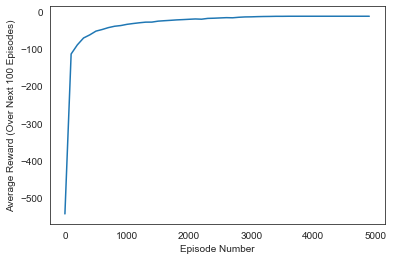

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  2  3  0  1  1  1  0  1  1  2  3]
 [ 0  1  1  1  1  1  1  1  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


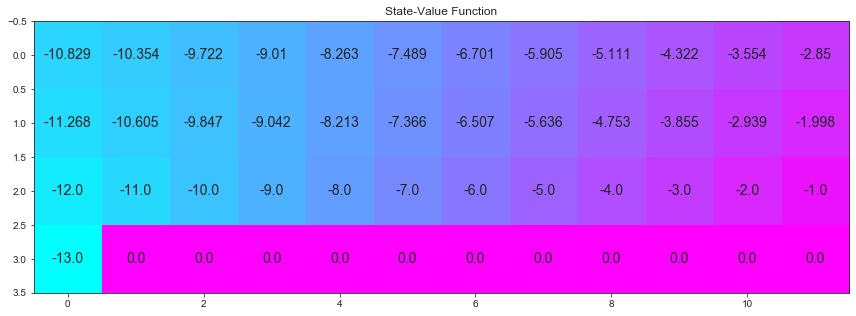

In [13]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### TD Control: Expected Sarsa

In [14]:
def update_Q_expsarsa(alpha, gamma, nA, eps, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]         # estimate in Q-table (for current state, action pair)
    policy_s = np.ones(nA) * eps / nA  # current policy (for next state S')
    policy_s[np.argmax(Q[next_state])] = 1 - eps + (eps / nA) # greedy action
    Qsa_next = np.dot(Q[next_state], policy_s)         # get value of state at next time step
    target = reward + (gamma * Qsa_next)               # construct target
    new_value = current + (alpha * (target - current)) # get updated value 
    return new_value

In [15]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    """Expected SARSA - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): step-size parameters for the update step
        gamma (float): discount factor
        plot_every (int): number of episodes to use when calculating average score
    """
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        score = 0             # initialize score
        state = env.reset()   # start episode
        eps = 0.005           # set value of epsilon
        
        while True:
            action = epsilon_greedy(Q, state, nA, eps)         # epsilon-greedy action selection
            next_state, reward, done, info = env.step(action)  # take action A, observe R, S'
            score += reward                                    # add reward to agent's score
            # update Q
            Q[state][action] = update_Q_expsarsa(alpha, gamma, nA, eps, Q, \
                                                 state, action, reward, next_state)        
            state = next_state              # S <- S'
            if done:
                tmp_scores.append(score)    # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Episode 10000/10000

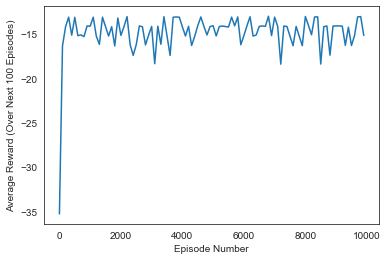

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  0  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


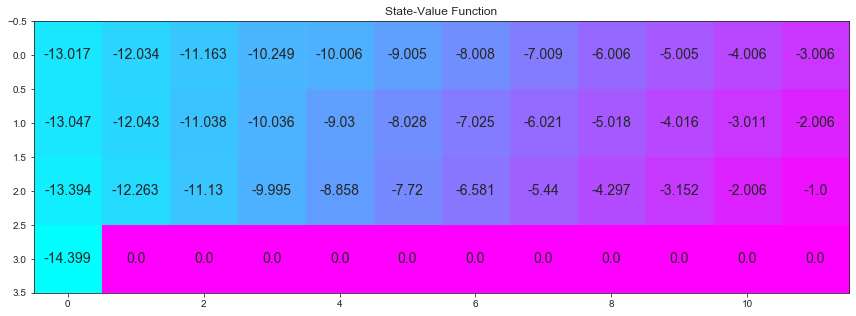

In [16]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])

In [19]:
(0.8*-12.8)+(0.2*(-1-0.6))

-10.560000000000002